In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [27]:
def grad_U(Ui, Yij, Vj, Ai, Bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - (np.dot(Ui, Vj) + Ai + Bj)))

def grad_V(Ui, Yij, Vj, Ai, Bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - (np.dot(Ui, Vj) + Ai + Bj)))

def grad_A(Ui, Yij, Vj, Ai, Bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ai multiplied by eta.
    """
    return eta * (reg * Ai - (Yij - (np.dot(Ui, Vj) + Ai + Bj)))
    
def grad_B(Ui, Yij, Vj, Ai, Bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Bj multiplied by eta.
    """
    return eta * (reg * Bj - (Yij - (np.dot(Ui, Vj) + Ai + Bj)))

def get_err(U, V, A, B, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
        
    reg_term = reg / 2 * (np.linalg.norm(U, ord='fro') +
                          np.linalg.norm(V, ord='fro') +
                          np.linalg.norm(A) +
                          np.linalg.norm(B) )
    
    cum_sum = 0
    
    for Yij in Y:
        cum_sum += np.square(np.dot(U[int(Yij[0])-1], V[int(Yij[1])-1]) + A[int(Yij[0])-1] + B[int(Yij[1])-1] - Yij[2])
    
    return cum_sum / (2 * len(Y)) + reg_term


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U and V to small random numbers
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    A = np.random.rand(M) - 0.5
    B = np.random.rand(N) - 0.5
    
    # Calculate initial error
    errors = [get_err(U, V, A, B, Y, reg=reg)]
    
    test_errors = [get_err(U, V, A, B, Y)]
    
    # Implement SGD
    for epoch in range(max_epochs):
        curr_ord = np.random.permutation(Y)
        
        # Loop through each data point in the epoch
        for point in curr_ord:
            i = int(point[0])
            j = int(point[1])
            Yij = point[2]
            i -= 1
            j -= 1
            du = grad_U(U[i], Yij, V[j], A[i], B[j], reg, eta)
            dv = grad_V(U[i], Yij, V[j], A[i], B[j], reg, eta)
            da = grad_A(U[i], Yij, V[j], A[i], B[j], reg, eta)
            db = grad_B(U[i], Yij, V[j], A[i], B[j], reg, eta)
            U[i] -= du
            V[j] -= dv
            A[i] -= da
            B[j] -= db
            
        # Compare errors and exit if we've converged
        errors.append(get_err(U, V, A, B, Y, reg=reg))
        test_errors.append(get_err(U, V, A, B, Y))
        if errors[-2] - errors[-1] < eps * (errors[0] - errors[1]) or errors[-2] - errors[-1] < 0:
            break
            
    return (U, V, A, B, get_err(U, V, A, B, Y))

In [25]:
# Load and manipulate train/test data
train = np.loadtxt('./data/train.txt', delimiter='\t')
test = np.loadtxt('./data/test.txt', delimiter='\t')

In [26]:
train[:, 2] -= np.mean(train, axis=0)[2]
test[:, 2] -= np.mean(test, axis=0)[2]

In [66]:
# Search through best possible parameters
M = 943
N = 1682
k = 20

E_in = []
E_out = []

regs = [1e-3, 1e-2, 1e-1, 1]
etas = [5e-4, 5e-3, 1e-2, 3e-2]

for reg in regs:
    E_in1 = []
    E_out1 = []
    for eta in etas:
        U, V, A, B, train_err = train_model(M, N, k, eta, reg, train)
        test_err = get_err(U, V, A, B, test)
        E_in1.append(train_err)
        E_out1.append(test_err)
    E_in.append(E_in1)
    E_out.append(E_out1)

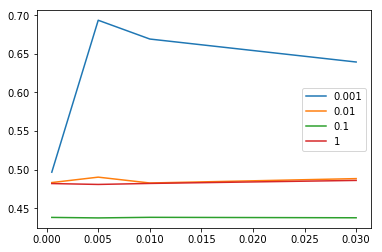

In [73]:
plt.figure()

for ind, reg in enumerate(regs):
    plt.plot(etas, E_out[ind], label=str(reg))
plt.legend()

In [29]:
# Search through best possible parameters
M = 943
N = 1682
k = 20

U, V, A, B, train_err = train_model(M, N, k, 0.03, 0.1, train)

In [92]:
print('Test error = ' + str(get_err(U, V, A, B, train)))

Test error = 0.358325880324


In [83]:
# Load data and packages for visualization
from proj2_helpers import *

def generate_proj(V_t, U):
    '''
    Finds the 2D projection of the "V" matrix.
    
    Inputs:
        V_t: the transpose of the V matrix
        
    Outputs:
        The 2D projection of the "V" matrix and transpose of "U"
    '''
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    scaler = StandardScaler(with_std=False)
    pca = PCA(n_components=2)
    
    V_t_scale = scaler.fit_transform(V_t)
    U_t_scale = scaler.transform(U)
    V_s = V_t_scale.T
    U_s = U_t_scale.T
    
    pca.fit(V_t_scale)
    print(pca.explained_variance_ratio_)
    A_12 = pca.components_
    
    return np.dot(A_12, V_s), np.dot(A_12, U_s)

def get_genre_ids(movies_df, genre, n=-1):
    '''Gets the first n movie ids of the given genre
    
    Inputs:
        movies_df: pandas dataframe with movie informations, including
        title, average rating, and genre information.
        
        genre: the genre to retrieve the ids for
        
        n: the number of ids to retrieve
        
    Output:
        a numpy array of integers corresponding to the id of the movies
    '''
    return movies_df[movies_df[genre]==1]['Movie Id'][:n]

def plot_proj(proj, movies_df, movie_ids, id_label=None, label_pts=True, suppress=False, box_color='yellow', size=(10, 10)):
    '''
    Plots the movies given by the ids on the 2D projection
    
    Inputs:
        proj: the 2D projection of the factorized "V" matrix. 
        
        movies_df: pandas dataframe with movie informations, including
        title, average rating, and genre information.
        
        movie_ids: numpy array of integers corresponding to the movies to plot.
        
        id_label: the label of the points in the legend. Relevant for multiple 
        datasets. (default = None)
        
        label_pts: boolean of whether to label plotted point with movie titles
        (default = True)
        
        suppress: boolean of whether to initialize and display the plot. To 
        plot multiple plots on the same figure, let suppress=True. (default = False)
        
        box_color: color of shading of the labels (default = yellow)
        
        size: size of the plot
        
    Outputs:
        None.
    '''
    if suppress == False:
        plt.figure(figsize=size)
    
    mask = np.zeros(len(proj[0]), dtype=bool)
    mask[movie_ids-1] = True
    
    x = proj[0][mask]
    y = proj[1][mask]
    
    plt.scatter(x, y, label=id_label)
    if label_pts == True:
        labels = [get_title_from_id(movies_df, movie_id) for movie_id in movie_ids]
        for label, x1, y1 in zip(labels, x, y):
            plt.annotate(
                label,
                xy=(x1, y1), xytext=(-5, 5),
                textcoords='offset points', ha='right', va='bottom'
                ,bbox=dict(boxstyle='round,pad=0.5', fc=box_color, alpha=0.2)
                #,arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
            )
    plt.axis('equal')
    if suppress == False:
        plt.show()

In [84]:
V_s, U_s = generate_proj(V, U)

[ 0.07854582  0.05838223]


In [6]:
data = np.loadtxt('data/data.txt', dtype=int)
movies = pd.read_csv('../data/movies.csv', sep=',', encoding='latin1')

In [17]:
avg = np.zeros(len(movies))
count = np.zeros(len(movies))
for movie_id in movies['Movie Id']:
    inds = (data[:,1] == movie_id)
    avg[movie_id-1] = (np.mean(data[:,2][inds]))
    count[movie_id-1] = np.sum(inds)

movies['Avg'] = avg
movies['Tot'] = count

In [93]:
# Set up dfs
pop_movies = movies.sort_values(by='Tot', ascending=False)
rate_movies = movies.sort_values(by='Avg', ascending=False)

# Set movie loc/IDs
pop_movies_ids = pop_movies['Movie Id'][:10]
rate_movies_ids = rate_movies['Movie Id'][:10]
com_movies_ids = pop_movies[pop_movies['Comedy'] == 1]['Movie Id'][:10]
doc_movies_ids = pop_movies[pop_movies['Documentary'] == 1]['Movie Id'][:10]
#hor_movies_ids = pop_movies[pop_movies['Horror'] == 1]['Movie Id'][:10]
rom_movies_ids = pop_movies[pop_movies['Romance'] == 1]['Movie Id'][:10]
rand_movies_ids = rate_movies[rate_movies['Tot'] > 100]['Movie Id'][:10]

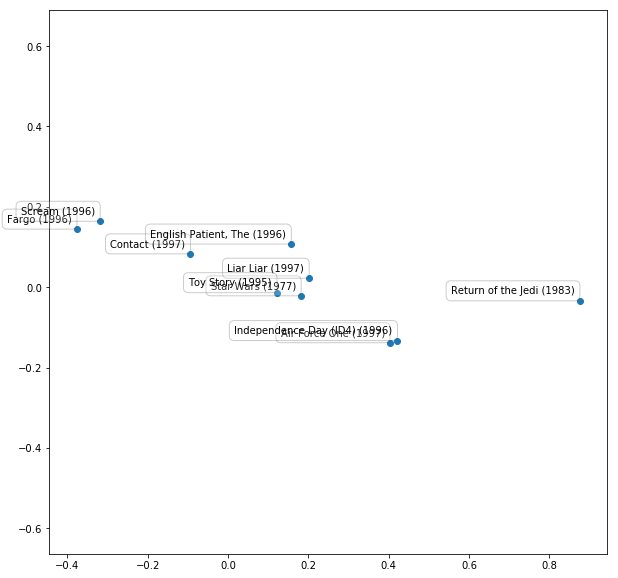

In [94]:
plt.figure(figsize=(15,15))
plot_proj(V_s, movies, pop_movies_ids, id_label='Most Rated', box_color='white', suppress=False)

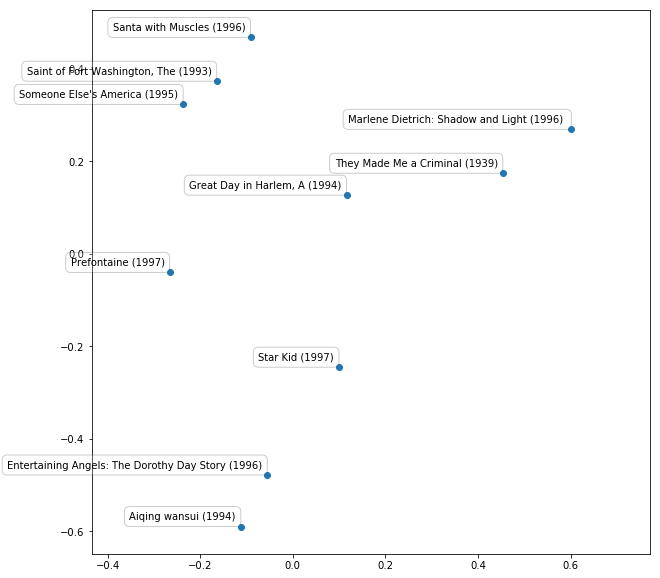

In [95]:
plt.figure(figsize=(15,15))
plot_proj(V_s, movies, rate_movies_ids, id_label='Highest Rated', box_color='white', suppress=False)

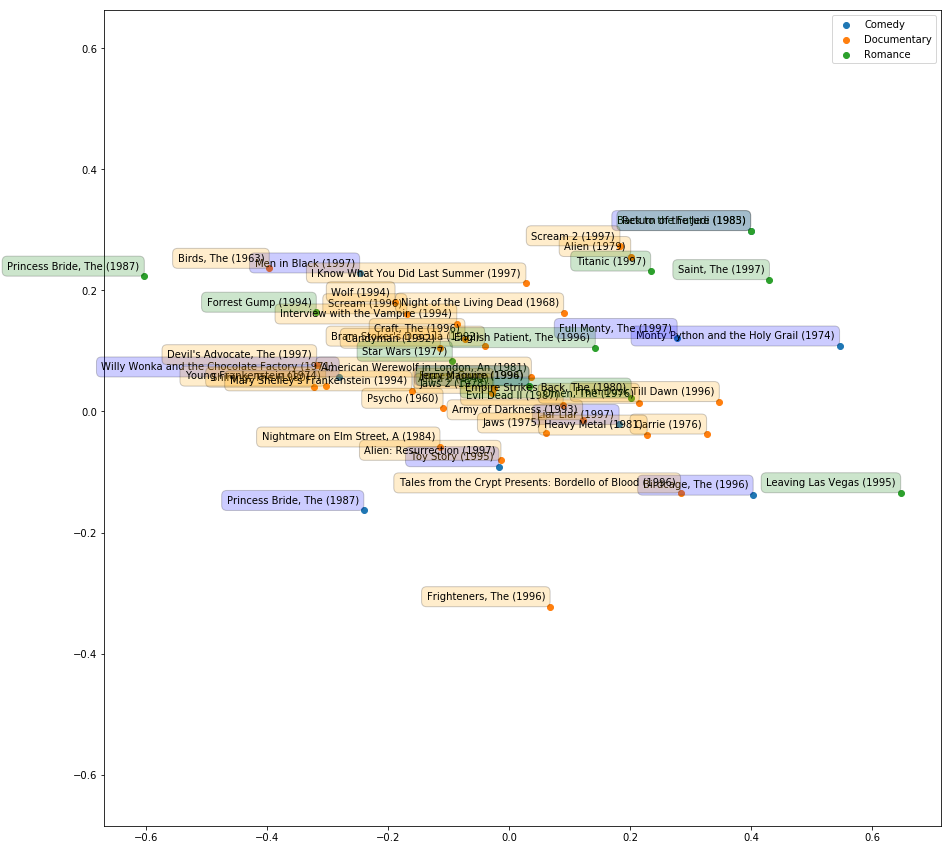

In [98]:
plt.figure(figsize=(15,15))
plot_proj(V_s, movies, com_movies_ids, id_label='Comedy', box_color='blue', suppress=True)
plot_proj(V_s, movies, hor_movies_ids, id_label='Documentary', box_color='orange', suppress=True)
plot_proj(V_s, movies, rom_movies_ids, id_label='Romance', box_color='green', suppress=True)
plt.legend()

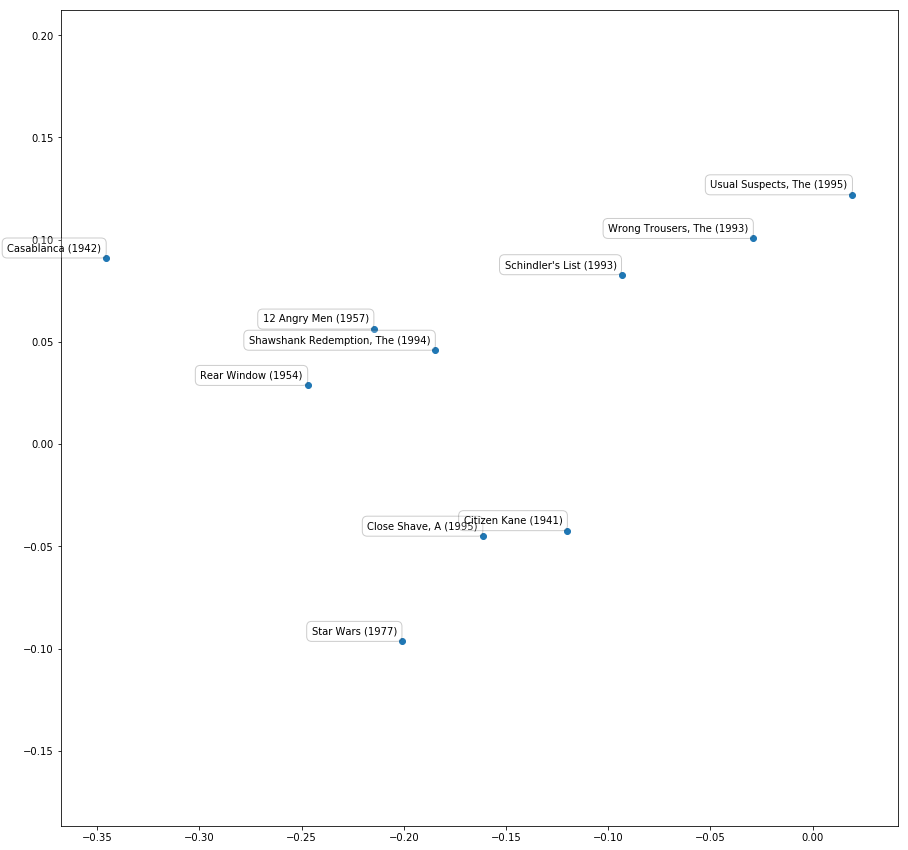

In [97]:
plt.figure(figsize=(15,15))
plot_proj(V_s, movies, rand_movies_ids, id_label='Random', box_color='white', suppress=True)